In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_profiling
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import os.path
from itertools import product

# Define evaluation metric

In [2]:
def calculate_RMSLE_score(predictions, targets):
    n = len(predictions)
    rms_logs = (np.log(targets + 1) - np.log(predictions + 1))**2
    score = np.sqrt(1/n * rms_logs.sum())
    return score

# Import the data

In [3]:
if os.path.exists('store_raw.h5'):
    print('Reading from hdf')
    
    with pd.HDFStore('store_raw.h5') as store_raw:
        building_raw = store_raw['building_raw']
        weather_train_raw = store_raw['weather_train_raw']
        weather_test_raw = store_raw['weather_test_raw']
        train_raw = store_raw['train_raw']
        test_raw = store_raw['test_raw']
    
else:
    print('Reading from csv')
    # You can access these data sets here: https://www.kaggle.com/c/ashrae-energy-prediction/data
    
    building_raw = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')
    weather_train_raw = pd.read_csv('ashrae-energy-prediction/weather_train.csv')
    weather_test_raw = pd.read_csv('ashrae-energy-prediction/weather_test.csv')
    train_raw = pd.read_csv('ashrae-energy-prediction/train.csv')
    test_raw = pd.read_csv('ashrae-energy-prediction/test.csv')
    
    with pd.HDFStore('store_raw.h5') as store_raw:
        store_raw['building_raw'] = building_raw
        store_raw['weather_train_raw'] = weather_train_raw
        store_raw['weather_test_raw'] = weather_test_raw
        store_raw['train_raw'] = train_raw
        store_raw['test_raw'] = test_raw 

Reading from hdf


# Check that same IDs in test and train

In [4]:
set(train_raw.building_id) == set(test_raw.building_id)

True

# Clean the data

## Identify issues

### Nans

In [5]:
weather_train_raw.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [6]:
weather_test_raw.isna().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
dtype: int64

In [7]:
train_raw.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [8]:
test_raw.isna().sum()

row_id         0
building_id    0
meter          0
timestamp      0
dtype: int64

In [9]:
building_raw.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

### Large values

In [10]:
greater_than_a_million = train_raw[train_raw.meter_reading > 1000000]
buildings_greater_than_a_million = set(greater_than_a_million.building_id)
len_greater_than_a_million = len(greater_than_a_million.building_id)

greater_than_ten_million = train_raw[train_raw.meter_reading > 10000000]
buildings_greater_than_ten_million = set(greater_than_ten_million.building_id)
len_greater_than_ten_million = len(greater_than_ten_million.building_id)

# one building has crazy high consumption readings - no others even have meter readings greater than a million

In [11]:
buildings_greater_than_a_million

{1099}

In [12]:
buildings_greater_than_ten_million

{1099}

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


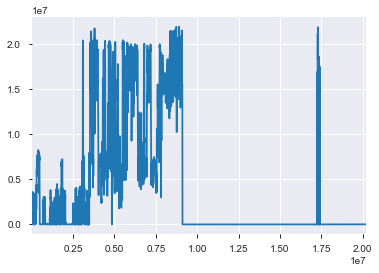

In [13]:
train_raw[train_raw.building_id == 1099][train_raw.meter == 2].meter_reading.plot()

In [14]:
building_raw[building_raw.building_id == 1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


In [40]:
del greater_than_a_million, buildings_greater_than_a_million, len_greater_than_a_million
del greater_than_ten_million, buildings_greater_than_ten_million, len_greater_than_ten_million

### Strange values

In [15]:
# It is reported in this discussion by @barnwellguy that All electricity meter is 0 until May 20 for site_id == 0.
buildings_site_0 = building_raw.building_id[building_raw.site_id == 0]

In [16]:
buildings_site_0

0        0
1        1
2        2
3        3
4        4
      ... 
100    100
101    101
102    102
103    103
104    104
Name: building_id, Length: 105, dtype: int64

In [17]:
elec_bildings_site_0 = train_raw[(train_raw.building_id.isin(list(buildings_site_0))) & (train_raw.meter == 0)]

In [18]:
elec_bildings_site_0.loc[:,'timestamp'] = pd.to_datetime(elec_bildings_site_0 ['timestamp'])

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [19]:
elec_bildings_site_0_pre_20may = elec_bildings_site_0[elec_bildings_site_0['timestamp'] < "2016-05-21"]

In [20]:
elec_bildings_site_0_pre_20may

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0000
1,1,0,2016-01-01 00:00:00,0.0000
2,2,0,2016-01-01 00:00:00,0.0000
3,3,0,2016-01-01 00:00:00,0.0000
4,4,0,2016-01-01 00:00:00,0.0000
...,...,...,...,...
7588571,100,0,2016-05-20 23:00:00,157.8080
7588572,101,0,2016-05-20 23:00:00,134.0550
7588573,102,0,2016-05-20 23:00:00,135.8740
7588574,103,0,2016-05-20 23:00:00,25.5278


In [21]:
elec_bildings_site_0_pre_20may[elec_bildings_site_0_pre_20may.meter_reading > 0]

,building_id,meter,timestamp,meter_reading
45,46,0,2016-01-01 00:00:00,53.2397
72,74,0,2016-01-01 00:00:00,43.0013
91,93,0,2016-01-01 00:00:00,52.4206
2321,20,0,2016-01-01 01:00:00,91.9886
2346,46,0,2016-01-01 01:00:00,53.6492
...,...,...,...,...
7588571,100,0,2016-05-20 23:00:00,157.8080
7588572,101,0,2016-05-20 23:00:00,134.0550
7588573,102,0,2016-05-20 23:00:00,135.8740
7588574,103,0,2016-05-20 23:00:00,25.5278


In [22]:
elec_bildings_site_0_pre_20may_pivoted = elec_bildings_site_0_pre_20may.pivot(index='timestamp',
                                     columns = 'building_id', 
                                     values = 'meter_reading')

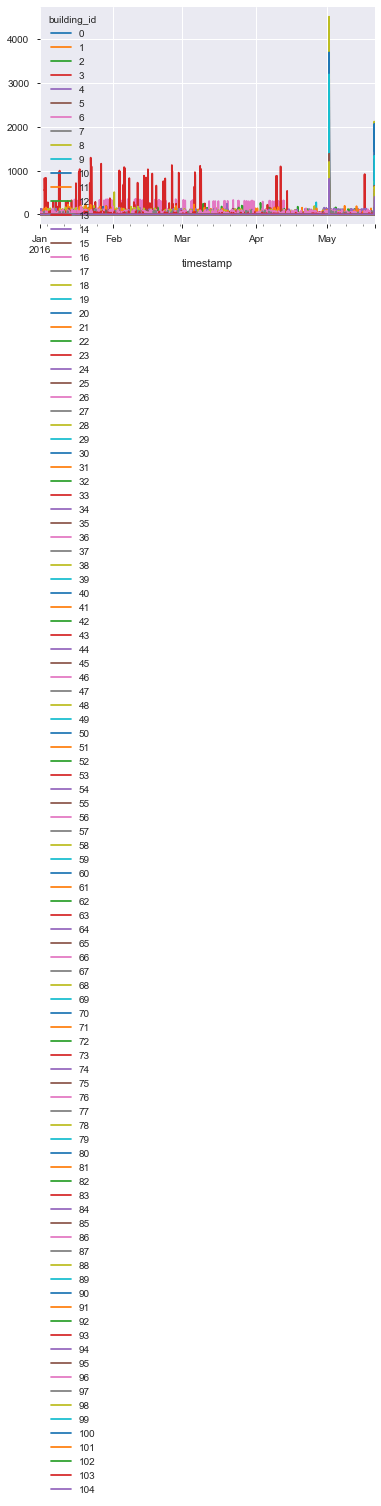

In [23]:
elec_bildings_site_0_pre_20may_pivoted.plot()
plt.show()

In [24]:
buidling_ids_with_data = set(
    elec_bildings_site_0_pre_20may[elec_bildings_site_0_pre_20may.meter_reading > 0].building_id)

In [25]:
buidling_ids_with_data

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104}

There is some data there for all of the buildings but it is very odd so delete

In [39]:
del buidling_ids_with_data, elec_bildings_site_0_pre_20may_pivoted, elec_bildings_site_0_pre_20may
del elec_bildings_site_0, buildings_site_0

### All the timestamps?

#### Weather train

In [26]:
min(weather_train_raw.timestamp)

'2016-01-01 00:00:00'

In [27]:
max(weather_train_raw.timestamp)

'2016-12-31 23:00:00'

In [28]:
len(weather_train_raw.timestamp)

139773

In [29]:
no_of_sites = len(set(weather_train_raw.site_id))

In [30]:
train_date_range = pd.date_range(start = min(weather_train_raw.timestamp), 
                                 end = max(weather_train_raw.timestamp),
                                 freq='H')

In [31]:
len(train_date_range) * no_of_sites

140544

so some weather data missing there

#### Weather test

In [32]:
min(weather_test_raw.timestamp)

'2017-01-01 00:00:00'

In [33]:
max(weather_test_raw.timestamp)

'2018-12-31 23:00:00'

In [34]:
len(weather_test_raw.timestamp)

277243

In [35]:
no_of_sites = len(set(weather_test_raw.site_id))
test_date_range = pd.date_range(start = min(weather_test_raw.timestamp), 
                                 end = max(weather_test_raw.timestamp),
                                 freq='H')
len(test_date_range) * no_of_sites

280320

So weather data is missing some timestamps

### So need to...

 - fill in NAN's in weather data
 - add missing dates to weather data and interpolate the blanks
 - Not sure what to do about building 1099's steam data - doesn't seem to be just one anomoly
 - Leave the nans in the building dataframe for now - I don't think we need to use those features
 - delete electric meter entries at site 0 buildings before the 20th of May 


## Fix them, reformat a few columns and add meter type names

In [36]:
def clean_weather_df(df_raw):
    df = df_raw.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    fulltime_range = pd.date_range(start = min(df.timestamp), 
                                 end = max(df.timestamp),
                                 freq='H')
    num_sites = list(set(df_raw.site_id))
    fulltime_temp = pd.DataFrame(product(num_sites, fulltime_range), columns=['site_id', 'timestamp'])
    df_fulltime = fulltime_temp.merge(df, on = ['site_id', 'timestamp'], how='left')
    df_fulltime = df_fulltime.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
    
    return df_fulltime

# set timestamps to timestamp dtypes, add meter type names
METER_MAP = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

def clean_meter_df(df,meter_map=METER_MAP):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['meter_type'] = df['meter'].map(meter_map)                                                                                                                              
    return df


In [44]:
if os.path.exists('store_clean.h5'):
    print('Reading from hdf')
    
    with pd.HDFStore('store_clean.h5') as store_clean:
        building = store_clean['building']
        weather_train = store_clean['weather_train']
        weather_test = store_clean['weather_test']
        train = store_clean['train']
        test = store_clean['test']
        
    del weather_train_raw, weather_test_raw, train_raw, test_raw, building_raw
    
else:
    print('Processing from raw data')
    
    test = clean_meter_df(test_raw) 
    train = clean_meter_df(train_raw)
    #remove odd data at site 0
    train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")') 
    building = building_raw
    
    weather_train = clean_weather_df(weather_train_raw)
    weather_test = clean_weather_df(weather_test_raw)
    
    del weather_train_raw, weather_test_raw

    with pd.HDFStore('store_clean.h5') as store_clean:
        store_clean['building'] = building
        store_clean['weather_train'] = weather_train
        store_clean['weather_test'] = weather_test
        store_clean['train'] = train
        store_clean['test'] = test
        
    del weather_train_raw, weather_test_raw, train_raw, test_raw, building_raw



Reading from hdf


In [46]:
weather_test.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        35040
dew_temperature           0
precip_depth_1_hr     52560
sea_level_pressure    17520
wind_direction            0
wind_speed                0
dtype: int64

In [47]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17568
dew_temperature           0
precip_depth_1_hr     26352
sea_level_pressure     8784
wind_direction            0
wind_speed                0
dtype: int64

In [48]:
train.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
meter_type       0
dtype: int64

In [49]:
len(weather_test)

280320

# 1. Have a look at the data more generally
### 1.1 Building metadata

In [50]:
building[building.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
100,0,100,Lodging/residential,24456,1968.0,NaN
101,0,101,Office,18860,1986.0,NaN
102,0,102,Office,15876,1983.0,NaN
103,0,103,Education,21657,2016.0,NaN


In [51]:
building

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [52]:
building.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [53]:
#building.profile_report(style={'full_width':True})

## 1.2 Weather training data

In [54]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.70,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.20,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.20,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.10,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.00,250.0,2.6
...,...,...,...,...,...,...,...,...,...
140539,15,2016-12-31 19:00:00,3.0,1.5,-8.0,-1.0,1007.55,180.0,5.7
140540,15,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7
140541,15,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1
140542,15,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6


In [55]:
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,140544.000000,140544.000000,122976.000000,140544.000000,114192.000000,131760.000000,140544.000000,140544.000000
mean,7.500000,14.355675,2.633782,7.299226,2.591872,1016.142669,179.566086,3.561964
std,4.609789,10.671025,2.755691,9.823550,11.570146,7.642530,110.780692,2.333866
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.750000,7.200000,0.000000,0.600000,0.000000,1011.700000,80.000000,2.100000
50%,7.500000,15.000000,2.000000,8.200000,0.000000,1016.400000,190.000000,3.100000
75%,11.250000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [56]:
#weather_train.profile_report()

In [57]:
weather_train['timestamp'].min()

Timestamp('2016-01-01 00:00:00')

In [58]:
weather_train['timestamp'].max()

Timestamp('2016-12-31 23:00:00')

## 1.3 Consumption training data

In [59]:
train

,building_id,meter,timestamp,meter_reading,meter_type
103,105,0,2016-01-01 00:00:00,23.3036,electricity
104,106,0,2016-01-01 00:00:00,0.3746,electricity
105,106,3,2016-01-01 00:00:00,0.0000,hotwater
106,107,0,2016-01-01 00:00:00,175.1840,electricity
107,108,0,2016-01-01 00:00:00,91.2653,electricity
...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.7500,electricity
20216096,1445,0,2016-12-31 23:00:00,4.8250,electricity
20216097,1446,0,2016-12-31 23:00:00,0.0000,electricity
20216098,1447,0,2016-12-31 23:00:00,159.5750,electricity


In [60]:
test

,row_id,building_id,meter,timestamp,meter_type
0,0,0,0,2017-01-01 00:00:00,electricity
1,1,1,0,2017-01-01 00:00:00,electricity
2,2,2,0,2017-01-01 00:00:00,electricity
3,3,3,0,2017-01-01 00:00:00,electricity
4,4,4,0,2017-01-01 00:00:00,electricity
...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,electricity
41697596,41697596,1445,0,2018-05-09 07:00:00,electricity
41697597,41697597,1446,0,2018-05-09 07:00:00,electricity
41697598,41697598,1447,0,2018-05-09 07:00:00,electricity


In [61]:
train.describe()

,building_id,meter,meter_reading
count,1.986989e+07,1.986989e+07,1.986989e+07
mean,8.122948e+02,6.739836e-01,2.153994e+03
std,4.189519e+02,9.349166e-01,1.545646e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.240000e+02,0.000000e+00,2.018670e+01
50%,9.030000e+02,0.000000e+00,8.200000e+01
75%,1.185000e+03,1.000000e+00,2.750100e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [62]:
#train.profile_report()

## 2 Combined data 

### 2.1 Stick all data together, add variables for hour of day and weekend/weekday and split on meter type

In [63]:
def join_input_data_and_multi_index(meter_readings_df, building_df, weather_df):
    
    # join meter and weather data
    building_n_meter = meter_readings_df.merge(building_df, on='building_id', how='left')
    all_df = building_n_meter.merge(weather_df, on=['site_id','timestamp'], how='left')
    
    # Add time related columns
    all_df['hour'] = all_df['timestamp'].dt.hour
    all_df['weekday'] = all_df['timestamp'].dt.dayofweek
    all_df['week_number'] = all_df['timestamp'].dt.week
    all_df['month'] = all_df['timestamp'].dt.month

    all_df['is_weekend'] = all_df['weekday'].apply(lambda x: 1 if x in [0,6] else 0)
    
    
    #multi index on building id and timestamp
    all_df = all_df.set_index(['building_id', 'timestamp']).sort_index()
    
    return all_df


def split_on_meter_type(all_df):
    
    elec = all_df[all_df['meter_type'] == 'electricity']
    chilledwater = all_df[all_df['meter_type'] == 'chilledwater']
    hotwater = all_df[all_df['meter_type'] == 'hotwater']
    steam = all_df[all_df['meter_type'] == 'steam']
    
    return elec, chilledwater, hotwater, steam

In [64]:
if os.path.exists('store_split_meters.h5'):
    print('Reading from hdf')
    
    with pd.HDFStore('store_split_meters.h5') as store_split_meters:
        elec_train = store_split_meters['elec_train']
        chilledwater_train = store_split_meters['chilledwater_train']
        hotwater_train = store_split_meters['hotwater_train']
        steam_train = store_split_meters['steam_train']

#         elec_test = store_split_meters['elec_test']
#         chilledwater_test = store_split_meters['chilledwater_test']
#         hotwater_test = store_split_meters['hotwater_test']
#         steam_test = store_split_meters['steam_test']
        

    
else:
    print('Processing from cleaned dfs')
    
    print('Merging')
    train_all = join_input_data_and_multi_index(train, building, weather_train)
#    test_all = join_input_data_and_multi_index(test, building, weather_test)
    
    print('Splitting')
    elec_train, chilledwater_train, hotwater_train, steam_train = split_on_meter_type(train_all)
#    elec_test, chilledwater_test, hotwater_test, steam_test = split_on_meter_type(test_all)
    
    
    print('Writing to store')
    with pd.HDFStore('store_split_meters.h5') as store_split_meters:
        
        
        store_split_meters['elec_train'] = elec_train
        store_split_meters['chilledwater_train'] = chilledwater_train
        store_split_meters['hotwater_train'] = hotwater_train
        store_split_meters['steam_train'] = steam_train

#         store_split_meters['elec_test'] = elec_test    
#         store_split_meters['chilledwater_test'] = chilledwater_test
#         store_split_meters['hotwater_test'] = hotwater_test
#         store_split_meters['steam_test'] = steam_test
#         del test_all


Reading from hdf


In [65]:
hotwater_train.isna().sum()

meter                       0
meter_reading               0
meter_type                  0
site_id                     0
primary_use                 0
square_feet                 0
year_built             697035
floor_count           1036419
air_temperature             0
cloud_coverage          69747
dew_temperature             0
precip_depth_1_hr      105375
sea_level_pressure          0
wind_direction              0
wind_speed                  0
hour                        0
weekday                     0
week_number                 0
month                       0
is_weekend                  0
dtype: int64

### 2.2 Correlate features with meter reading for each building and meter type

In [66]:
CORRELATORS = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr', 'sea_level_pressure',
               'wind_direction','wind_speed', 'hour', 'weekday', 'month', 'is_weekend']
def produce_correlation_df(train_df, y_variable='meter_reading', buildings=None,  correlators=CORRELATORS):
    if buildings==None:
        buildings = list(set(train_df.index.get_level_values('building_id')))
    correlations_df = pd.DataFrame()
    for building_id in buildings:
        df =  train_df.loc[building_id] 
        correlations = df.corr()[y_variable]
        correlations = correlations[correlators]
        correlations_df[building_id] = correlations
    correlations_df['mean'] = correlations_df.mean(axis=1)
    correlations_df['st_dev'] = correlations_df.std(axis=1)
    correlations_df = correlations_df.T
    correlations_df.sort_values(by='mean', axis=1, ascending=False)
    
    return correlations_df

def plot_correlation_distribution(correlations_df):
    for variable in correlations_df.columns:
        sns.distplot(list(correlations_df[variable].dropna()), label=variable)
    plt.legend()
    plt.show()

def plot_correlation_values(correlations_df):
    correlations_df.drop(['mean', 'st_dev'], axis=0).plot()
    plt.show()
    
def explore_correlations(buildings_correlations):
    
    plot_correlation_values(buildings_correlations)
    plot_correlation_distribution(buildings_correlations)
    plot_correlation_distribution(buildings_correlations[['air_temperature', 'dew_temperature']])

In [67]:
# take a subset of the buildings to check 
building_subset = list(range(30))
elec_train_subset = elec_train[elec_train.index.get_level_values('building_id').isin(building_subset)]
elec_buildings_subset_correlations = produce_correlation_df(elec_train_subset, buildings=building_subset)

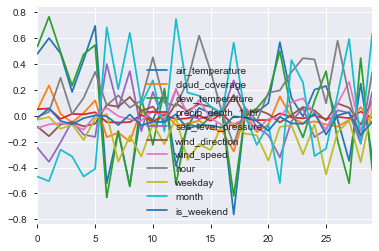

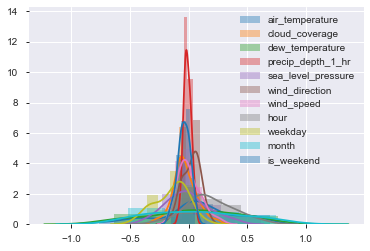

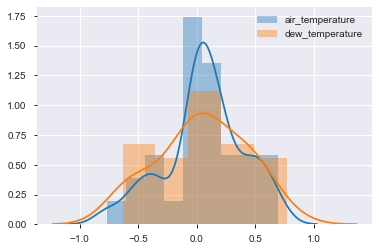

In [68]:
explore_correlations(elec_buildings_subset_correlations)

In [69]:
del building_subset, elec_train_subset, elec_buildings_subset_correlations

#### Electric meters

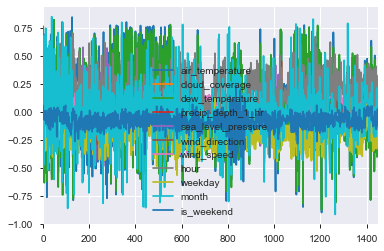

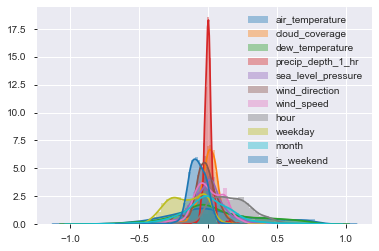

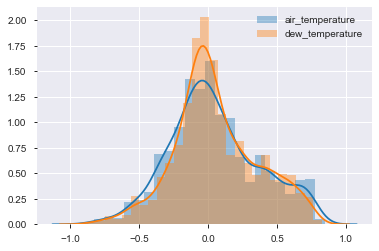

In [70]:
elec_correlations = produce_correlation_df(elec_train)
explore_correlations(elec_correlations)

In [71]:
elec_correlations

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekday,month,is_weekend
0,0.479453,0.047962,0.535181,0.050461,-0.247728,-0.084806,-0.095086,-0.009434,-0.030687,-0.469898,-0.016915
1,0.600476,0.234716,0.765343,0.056727,-0.355877,-0.157504,-0.066455,0.030900,-0.008356,-0.505148,0.057425
2,0.483044,0.014300,0.492570,-0.023997,-0.205388,-0.066620,-0.057822,0.293703,-0.100593,-0.261834,-0.039994
3,0.183932,-0.052511,0.232867,0.014609,-0.042823,-0.049127,-0.066589,0.013243,-0.066523,-0.314317,-0.065291
4,0.432766,0.022912,0.474896,0.011035,-0.145271,-0.081540,-0.108159,0.138171,-0.186284,-0.469822,-0.018406
...,...,...,...,...,...,...,...,...,...,...,...
1446,-0.069268,-0.017234,0.007961,0.008024,0.038454,-0.095599,-0.068407,0.004068,-0.304842,0.019892,-0.118016
1447,0.052228,0.033906,-0.016076,-0.001984,0.055434,0.076326,0.051861,0.283703,0.009565,0.109691,0.026366
1448,-0.286418,-0.004531,-0.223446,-0.031048,0.055149,-0.048086,0.016022,-0.033078,-0.322307,-0.033290,-0.124148
mean,0.046573,0.004808,0.055722,0.001250,-0.001781,-0.029812,0.004165,0.167293,-0.156134,-0.004406,-0.078404


#### Chilled water meters

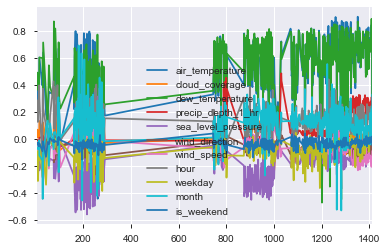

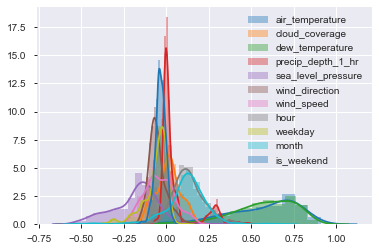

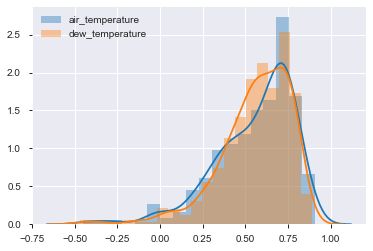

In [72]:
chilledwater_correlations = produce_correlation_df(chilledwater_train)
explore_correlations(chilledwater_correlations)

In [73]:
chilledwater_correlations

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekday,month,is_weekend
7,0.424002,0.071635,0.494088,-0.004128,-0.227254,-0.084170,-0.049827,0.287845,-0.087728,-0.066949,-0.039489
9,0.268141,0.012373,0.365835,-0.010351,-0.155910,-0.067023,-0.118621,0.128753,-0.308224,-0.072108,-0.023579
13,0.323971,0.038770,0.393213,-0.017356,-0.148888,-0.057188,-0.073561,0.342243,-0.120963,-0.012673,-0.045396
14,0.334491,0.014743,0.364066,-0.019171,-0.123496,-0.038146,-0.064284,0.399063,-0.153019,-0.006096,-0.052010
15,0.606094,0.136250,0.606535,0.011417,-0.229724,-0.081948,-0.069280,0.304497,-0.031344,-0.119134,-0.029884
...,...,...,...,...,...,...,...,...,...,...,...
1411,0.733632,0.047392,0.725497,0.303163,-0.036241,-0.071001,-0.140169,0.153633,0.022311,0.126722,0.004288
1412,0.678932,0.025365,0.739027,0.260449,-0.084249,-0.133077,-0.198174,0.059920,0.002571,0.115970,0.021220
1413,-0.036651,0.009435,-0.077512,0.035317,0.001914,-0.036326,-0.086417,0.031942,0.114168,0.332291,-0.044914
mean,0.556128,0.010204,0.561056,0.054458,-0.184050,-0.052474,-0.039252,0.134112,-0.062602,0.117880,-0.033610


#### Hot water meters

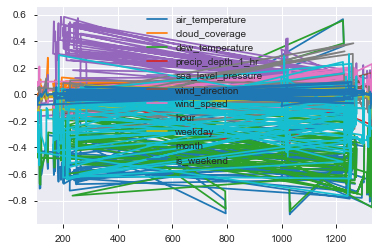

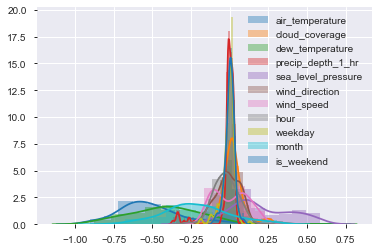

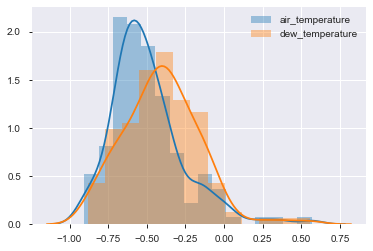

In [74]:
hotwater_correlations = produce_correlation_df(hotwater_train)
explore_correlations(hotwater_correlations)

In [75]:
hotwater_correlations

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekday,month,is_weekend
1028,-0.724895,NaN,-0.719822,-0.259861,0.166679,0.000623,0.136966,0.109893,-0.130129,-0.310150,-0.054951
1029,-0.903725,NaN,-0.881313,-0.367781,0.108897,-0.014381,0.172808,0.045401,-0.007495,-0.336249,0.020300
1030,-0.900860,NaN,-0.876608,-0.331058,0.131220,-0.000029,0.173128,-0.047523,-0.018002,-0.278813,0.022347
1031,-0.857283,NaN,-0.814728,-0.295363,0.113775,-0.013870,0.129094,-0.069886,-0.014902,-0.342549,0.023081
1032,-0.894230,NaN,-0.870511,-0.340441,0.092877,-0.003847,0.188206,0.049742,-0.017053,-0.322075,-0.000997
...,...,...,...,...,...,...,...,...,...,...,...
1018,-0.300448,0.107667,-0.112113,0.030009,0.089513,-0.018463,-0.015632,0.012143,0.017224,-0.216491,0.052807
1021,-0.022167,-0.067479,-0.129746,-0.004038,0.084693,-0.006006,-0.022745,-0.038819,-0.004071,0.188373,0.003876
1022,-0.644122,0.251403,-0.503518,0.004990,0.420730,-0.013539,-0.132544,-0.104196,-0.025858,-0.469525,0.002485
mean,-0.500971,0.024698,-0.410522,-0.017821,0.198446,-0.010355,0.004840,-0.021539,-0.008467,-0.217748,0.000295


#### Steam meters

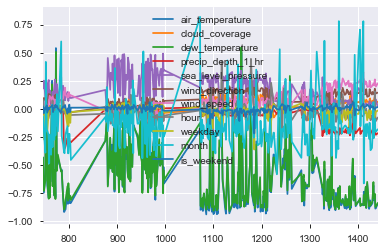

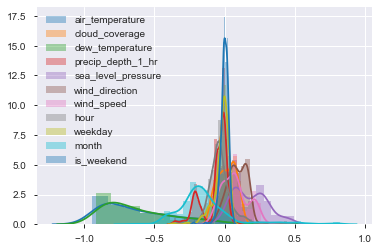

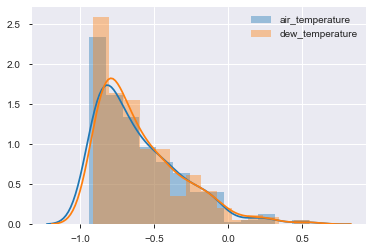

In [76]:
steam_correlations = produce_correlation_df(steam_train)
explore_correlations(steam_correlations)

In [77]:
steam_correlations

,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekday,month,is_weekend
745,-0.437014,-0.055568,-0.432730,-0.046587,0.180571,0.057548,0.037162,0.079282,-0.273449,-0.066190,0.021028
747,-0.747052,-0.022598,-0.732330,-0.039746,0.250665,0.096633,0.046386,-0.041600,-0.069678,-0.202884,-0.039238
750,-0.586364,0.005708,-0.638546,-0.031567,0.108340,0.088990,0.066371,-0.037588,0.003088,-0.390740,0.012278
751,0.221421,-0.047647,0.205491,0.004521,0.090945,-0.028328,-0.034415,0.005940,-0.016350,0.417677,-0.000337
753,-0.261218,0.007079,-0.277426,-0.011184,0.011643,0.046622,0.023403,0.027700,-0.009569,-0.191835,0.030470
...,...,...,...,...,...,...,...,...,...,...,...
1437,-0.889911,0.071112,-0.875337,-0.216061,0.073171,0.153968,0.223455,-0.059314,-0.053340,-0.202942,0.002921
1438,-0.884872,0.043236,-0.872149,-0.231689,0.082951,0.136652,0.198182,-0.109866,-0.028427,-0.204159,0.011748
1442,-0.847074,0.063927,-0.838951,-0.217967,0.013701,0.143993,0.225977,-0.078038,-0.014756,-0.182990,0.014930
mean,-0.609241,0.015135,-0.594468,-0.067150,0.178128,0.088515,0.072631,-0.029219,-0.021971,-0.139339,-0.000548


## 2.3 Integrate data over a week and look at impact of weather variables then (to take away time dependance)

In [78]:
WEEKLY_ATTRIBUTES = ['meter_reading','air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
                     'sea_level_pressure', 'wind_direction','wind_speed', 'week_number', 'month']
WEEKLY_CORRELATORS = ['air_temperature', 'cloud_coverage', 'dew_temperature','precip_depth_1_hr',
                      'sea_level_pressure', 'wind_direction','wind_speed', 'month']

In [79]:
def produce_weekly_average_data(df, weekly_attributes=WEEKLY_ATTRIBUTES):
    df_weekly_means = df[weekly_attributes].groupby(['building_id', 'week_number']).mean()
    df_weekly_means['building_id'] = list(df_weekly_means.index.get_level_values('building_id'))
    return df_weekly_means

def produce_weekly_degree_hours(df, set_point_temp):
    df_temp = df[['meter_reading','air_temperature','week_number']].copy()
    df_temp['delta_temp'] = df_temp['air_temperature'] - set_point_temp
    df_temp = df_temp.drop(columns='air_temperature')
    df_weekly_dh = df_temp.groupby(['building_id', 'week_number']).sum()  
    df_weekly_dh['building_id'] = list(df_weekly_dh.index.get_level_values('building_id'))
    return df_weekly_dh
    

In [80]:
set_point_C = 13

#### Electric meters

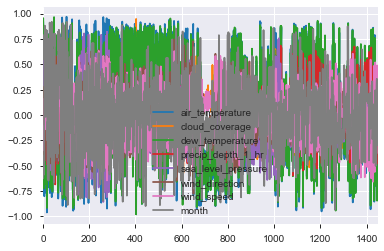

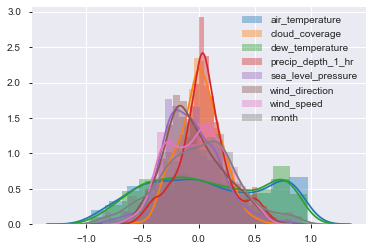

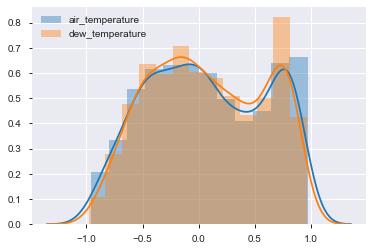

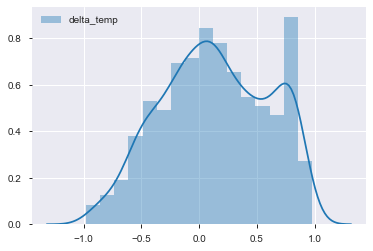

In [81]:
elec_weekly_means_df = produce_weekly_average_data(elec_train)
elec_weekly_means_corrs = produce_correlation_df(elec_weekly_means_df, correlators=WEEKLY_CORRELATORS)

elec_weekly_dh_df = produce_weekly_degree_hours(elec_train, set_point_C )
elec_weekly_dh_corrs = produce_correlation_df(elec_weekly_dh_df , correlators=['delta_temp'])

explore_correlations(elec_weekly_means_corrs)
plot_correlation_distribution(elec_weekly_dh_corrs )

#### Chilled water meters

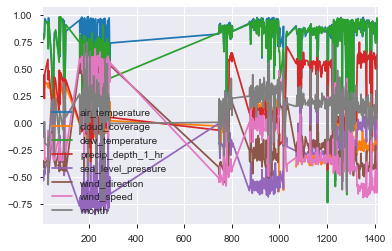

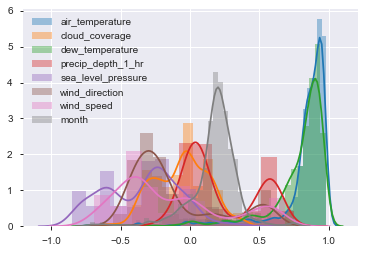

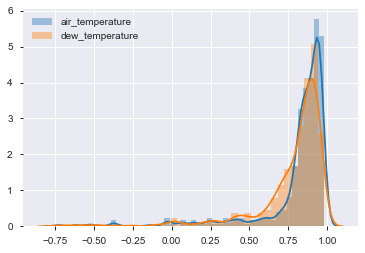

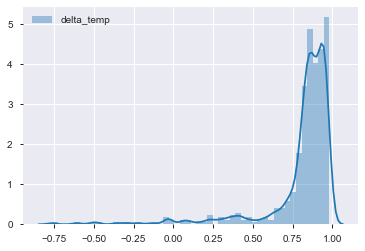

In [82]:
chilledwater_weekly_means_df = produce_weekly_average_data(chilledwater_train)
chilledwater_weekly_means_corrs = produce_correlation_df(chilledwater_weekly_means_df ,
                                                         correlators=WEEKLY_CORRELATORS)

chilledwater_weekly_dh_df = produce_weekly_degree_hours(chilledwater_train, set_point_C )
chilledwater_weekly_dh_corrs = produce_correlation_df(chilledwater_weekly_dh_df, correlators=['delta_temp'])

explore_correlations(chilledwater_weekly_means_corrs)
plot_correlation_distribution(chilledwater_weekly_dh_corrs )

#### Hot water meters

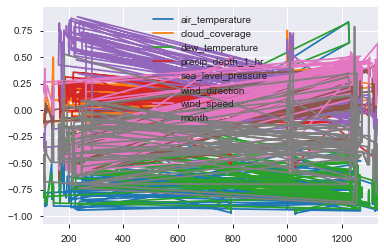

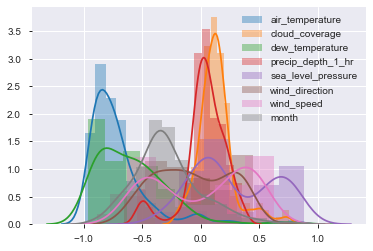

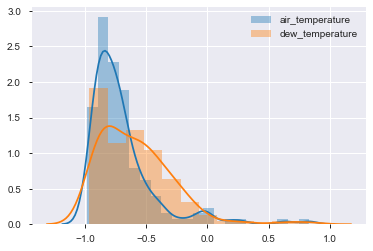

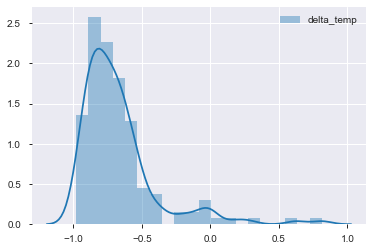

In [83]:
hotwater_weekly_means_df = produce_weekly_average_data(hotwater_train)
hotwater_weekly_means_corrs = produce_correlation_df(hotwater_weekly_means_df , correlators=WEEKLY_CORRELATORS)

hotwater_weekly_dh_df = produce_weekly_degree_hours(hotwater_train, set_point_C )
hotwater_weekly_dh_corrs = produce_correlation_df(hotwater_weekly_dh_df, correlators=['delta_temp'])

explore_correlations(hotwater_weekly_means_corrs)
plot_correlation_distribution(hotwater_weekly_dh_corrs )

#### Steam meters

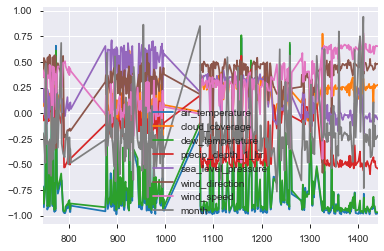

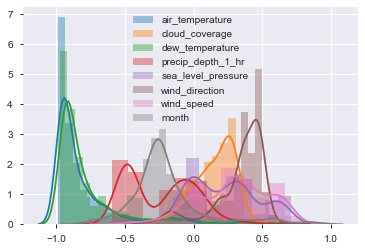

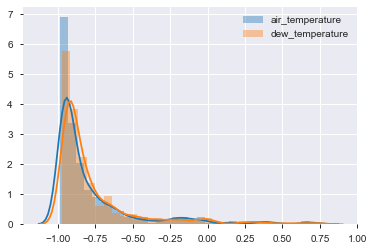

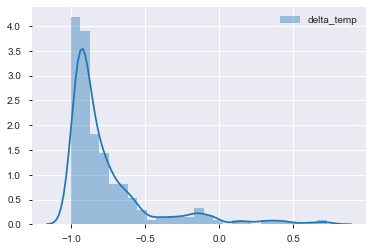

In [84]:
steam_weekly_means_df = produce_weekly_average_data(steam_train)
steam_weekly_means_corrs = produce_correlation_df(steam_weekly_means_df , correlators=WEEKLY_CORRELATORS)

steam_weekly_dh_df = produce_weekly_degree_hours(steam_train, set_point_C )
steam_weekly_dh_corrs = produce_correlation_df(steam_weekly_dh_df, correlators=['delta_temp'])

explore_correlations(steam_weekly_means_corrs)
plot_correlation_distribution(steam_weekly_dh_corrs)

## 2.4 Compare strength of different correlators

In [114]:
def compare_distributions(df_dict, variable_name_dict, title):
    for df_name, df in df_dict.items():
        sns.distplot(list(df[variable_name_dict[df_name]].dropna()), label=df_name)
    plt.title(title)
    plt.legend()
    plt.show()


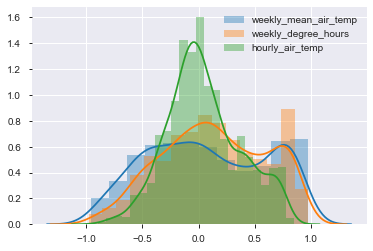

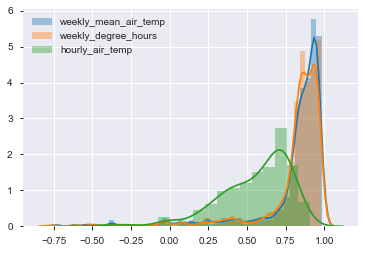

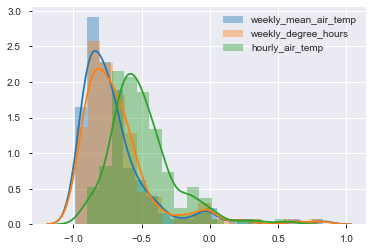

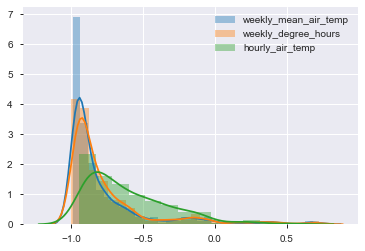

In [86]:
variable_name_dict = {'weekly_mean_air_temp':'air_temperature',
                      'weekly_degree_hours':'delta_temp',
                      'hourly_air_temp':'air_temperature'}

compare_distributions({'weekly_mean_air_temp':elec_weekly_means_corrs, 
                      'weekly_degree_hours':elec_weekly_dh_corrs,
                      'hourly_air_temp':elec_correlations},
                      variable_name_dict,
                     'elec')

compare_distributions({'weekly_mean_air_temp':chilledwater_weekly_means_corrs,
                      'weekly_degree_hours':chilledwater_weekly_dh_corrs,
                      'hourly_air_temp':chilledwater_correlations},
                     variable_name_dict, 'chilledwater')

compare_distributions({'weekly_mean_air_temp':hotwater_weekly_means_corrs,
                      'weekly_degree_hours':hotwater_weekly_dh_corrs,
                      'hourly_air_temp':hotwater_correlations},
                     variable_name_dict, 'hotwater')

compare_distributions({'weekly_mean_air_temp':steam_weekly_means_corrs,
                      'weekly_degree_hours':steam_weekly_dh_corrs,
                      'hourly_air_temp':steam_correlations},
                     variable_name_dict,
                     'steam')

# 3. Linear regression model based on air temperature only

Assume that form of equation is meter_reading = A.T(t) + B + f(t) where B = A.T_setpoint. <br>

In [87]:
def fit_linear_regression_to_air_temp_data(df):
    
    building_ids = list(set(df.index.get_level_values('building_id')))
    df_results = pd.DataFrame(index=building_ids, columns = ['r_sq', 'intercept', 'temp_coef', 'set_point_temp'])
    df_results.index.rename('building_id', inplace=True)
    
    for building_id in building_ids:
        building_df = df.loc[building_id]
        y=building_df['meter_reading'].to_numpy()
        x=building_df['air_temperature'].to_numpy().reshape(-1, 1)
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        x=imp_mean.fit_transform(x)
        model=LinearRegression(n_jobs=-1).fit(x,y)
        r_sq = model.score(x, y)
        df_results.loc[building_id, 'r_sq'] = r_sq
        df_results.loc[building_id, 'intercept'] = model.intercept_
        df_results.loc[building_id, 'temp_coef'] = model.coef_[0]
        df_results.loc[building_id, 'set_point_temp'] = -model.intercept_/model.coef_[0]
        
    for col in list(df_results):
        df_results[col] = pd.to_numeric(df_results[col])
        
    return df_results

## 3.1 Air temperature - weekly averages

Integrate out the time dependancy by looking at entire weeks

Start by just fitting a from weekly_meter_reading = A.T_mean + B

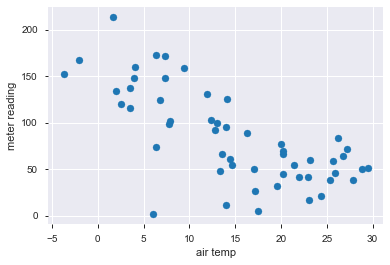

In [88]:
building_df = steam_weekly_means_df.loc[745]
y=building_df['meter_reading'].to_numpy()
x=building_df['air_temperature'].to_numpy()
plt.xlabel('air temp')
plt.ylabel('meter reading')
plt.scatter(x,y)
plt.show()

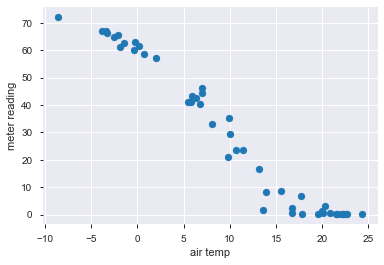

In [89]:
building_df = steam_weekly_means_df.loc[1442]
y=building_df['meter_reading'].to_numpy()
x=building_df['air_temperature'].to_numpy()
plt.xlabel('air temp')
plt.ylabel('meter reading')
plt.scatter(x,y)
plt.show()

### 3.1.1 Fit model

In [90]:
df_steam_weekly_results = fit_linear_regression_to_air_temp_data(steam_weekly_means_df)
df_chilledwater_weekly_results = fit_linear_regression_to_air_temp_data(chilledwater_weekly_means_df)
df_hotwater_weekly_results = fit_linear_regression_to_air_temp_data(hotwater_weekly_means_df)
df_elec_weekly_results = fit_linear_regression_to_air_temp_data(elec_weekly_means_df) 

In [91]:
#stick them all together for use later
df_elec_weekly_results['meter'] = 0
df_chilledwater_weekly_results['meter'] = 1
df_steam_weekly_results['meter'] = 2
df_hotwater_weekly_results['meter'] = 3


df_weekly_results = pd.concat([df_elec_weekly_results, df_chilledwater_weekly_results,
           df_hotwater_weekly_results, df_steam_weekly_results])

In [92]:
df_weekly_results

,r_sq,intercept,temp_coef,set_point_temp,meter
building_id,,,,,
0,0.615900,6.583601,9.206641,-0.715093,0
1,0.849470,-11.319531,5.267539,2.148922,0
2,0.654240,-27.299266,2.030058,13.447529,0
3,0.214723,158.481980,8.828337,-17.951510,0
4,0.530981,891.542371,27.284617,-32.675642,0
...,...,...,...,...,...
1434,0.838503,933.131524,-42.112922,22.157843,2
1436,0.883047,2140.162296,-76.541346,27.960866,2
1437,0.943732,1661.318692,-68.677389,24.190184,2


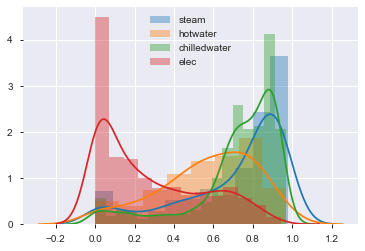

In [93]:
variable_name_dict = {'steam':'r_sq',
                      'hotwater':'r_sq',
                      'chilledwater':'r_sq',
                      'elec':'r_sq'}

compare_distributions({'steam':df_steam_weekly_results,
                      'hotwater': df_hotwater_weekly_results,
                      'chilledwater':df_chilledwater_weekly_results,
                      'elec': df_elec_weekly_results},
                      variable_name_dict,
                      'r_sq')

### 3.1.2 Compare R squared values from weekly averages between building primary uses

In [94]:
#add data on building primary use to explore impact
df_elec_weekly_results_buildtype = df_elec_weekly_results.join(building['primary_use'])
df_steam_weekly_results_buildtype = df_steam_weekly_results.join(building['primary_use'])
df_chilledwater_weekly_results_buildtype = df_chilledwater_weekly_results.join(building['primary_use'])
df_hotwater_weekly_results_buildtype = df_hotwater_weekly_results.join(building['primary_use'])

In [115]:
def compare_building_uses(df, building, variable, title):
    for use in set(building['primary_use']):
        sns.distplot(list(df[df['primary_use']==use][variable].dropna()), label=use)
        plt.title(title)
        # Put the legend out of the figure
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

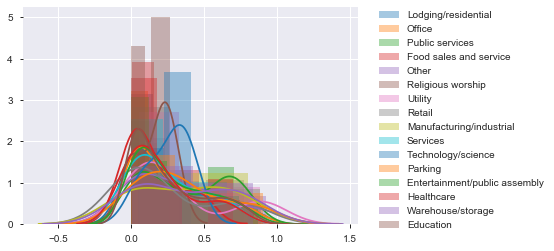

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


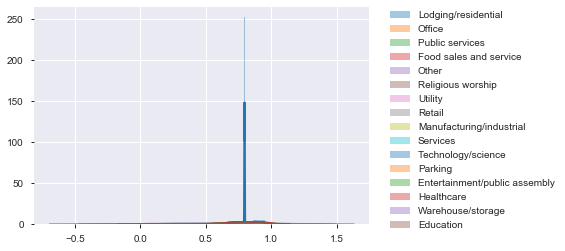

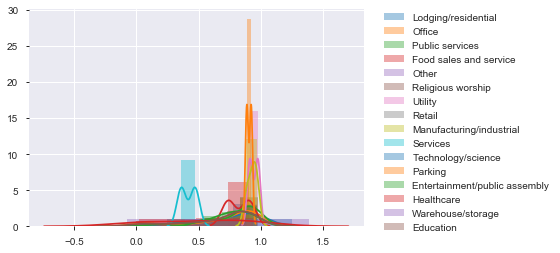

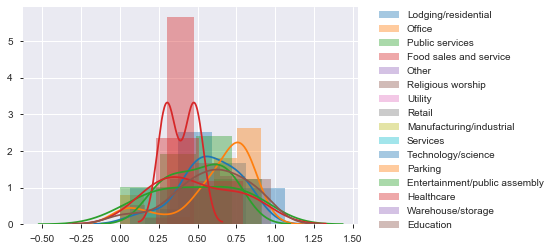

In [96]:
compare_building_uses(df_elec_weekly_results_buildtype, building, 'r_sq',
                      "Electric meter - comparison of Rsq between building types")
compare_building_uses(df_chilledwater_weekly_results_buildtype, building,'r_sq',
                      "Chilled Water meter - comparison of Rsq between building types")
compare_building_uses(df_steam_weekly_results_buildtype, building, 'r_sq',
                      "Steam meter - comparison of Rsq between building types")
compare_building_uses(df_hotwater_weekly_results_buildtype, building,'r_sq',
                      "Hot water meter - comparison of R-sq between building types")

In [97]:
del df_elec_weekly_results_buildtype, df_steam_weekly_results_buildtype
del df_chilledwater_weekly_results_buildtype
del df_hotwater_weekly_results_buildtype 

### 3.1.3 Apply coefficients to hourly dataset

In [194]:
def add_temp_based_predictions(df, df_lin_reg_results):
    
    df = df.reset_index()
    df_lin_reg_results = df_lin_reg_results[['r_sq', 'temp_coef', 'intercept',
                                             'set_point_temp', 'meter']].reset_index()
    df = df.merge(df_lin_reg_results, how='left', on=['building_id', 'meter'])
    df = df.set_index(['building_id', 'timestamp'])
    
    df['temp_based_prediction'] = df['temp_coef'] * df['air_temperature'] + df['intercept']
    
    # remove sub-zero predictions
    df['temp_based_prediction_no_negs'] = df['temp_based_prediction'].loc[:,df['temp_based_prediction'] < 0] = 0
    
    if 'meter_reading' in df.columns:
        df['residual'] = df['meter_reading'] - df['temp_based_prediction']
        df['squared_log_error'] = (np.log(df['temp_based_prediction'] + 1) - np.log(df['meter_reading'] + 1))**2
        df['squared_log_error_no_negs'] = (np.log(df['temp_based_prediction_no_negs'] + 1) - np.log(df['meter_reading'] + 1))**2
    return df

In [215]:
chilledwater_train_weekly_temp_preds

meter  meter_reading    meter_type  site_id  \
building_id timestamp                                                          
7           2016-02-29 09:00:00      1      1857.2600  chilledwater        0   
            2016-02-29 10:00:00      1      2659.2500  chilledwater        0   
            2016-02-29 11:00:00      1      2912.5100  chilledwater        0   
            2016-02-29 12:00:00      1      3039.1500  chilledwater        0   
            2016-02-29 13:00:00      1      3207.9900  chilledwater        0   
...                                ...            ...           ...      ...   
1413        2016-12-31 19:00:00      1         2.9235  chilledwater       15   
            2016-12-31 20:00:00      1         2.7167  chilledwater       15   
            2016-12-31 21:00:00      1         2.9400  chilledwater       15   
            2016-12-31 22:00:00      1         2.8698  chilledwater       15   
            2016-12-31 23:00:00      1         2.5314  chilledwater       15   

                                         primary_use  square_feet  year_built  \
building_id timestamp                                                           
7           2016-02-29 09:00:00            Education       121074      1989.0   
            2016-02-29 10:00:00            Education       121074      1989.0   
            2016-02-29 11:00:00            Education       121074      1989.0   
            2016-02-29 12:00:00            Education       121074      1989.0   
            2016-02-29 13:00:00            Education       121074      1989.0   
...                                              ...          ...         ...   
1413        2016-12-31 19:00:00  Lodging/residential        65999      1975.0   
            2016-12-31 20:00:00  Lodging/residential        65999      1975.0   
            2016-12-31 21:00:00  Lodging/residential        65999      1975.0   
            2016-12-31 22:00:00  Lodging/residential        65999      1975.0   
            2016-12-31 23:00:00  Lodging/residential        65999      1975.0   

                                 floor_count  air_temperature  cloud_coverage  \
building_id timestamp                                                           
7           2016-02-29 09:00:00          NaN             12.8             6.0   
            2016-02-29 10:00:00          NaN             12.2             6.0   
            2016-02-29 11:00:00          NaN             12.8             6.0   
            2016-02-29 12:00:00          NaN             11.1             6.0   
            2016-02-29 13:00:00          NaN             13.3             6.0   
...                                      ...              ...             ...   
1413        2016-12-31 19:00:00          NaN              3.0             1.5   
            2016-12-31 20:00:00          NaN              2.8             2.0   
            2016-12-31 21:00:00          NaN              2.8             2.0   
            2016-12-31 22:00:00          NaN              2.2             2.0   
            2016-12-31 23:00:00          NaN              1.7             2.0   

                                 ...  is_weekend      r_sq   temp_coef  \
building_id timestamp            ...                                     
7           2016-02-29 09:00:00  ...           1  0.634695  288.967231   
            2016-02-29 10:00:00  ...           1  0.634695  288.967231   
            2016-02-29 11:00:00  ...           1  0.634695  288.967231   
            2016-02-29 12:00:00  ...           1  0.634695  288.967231   
            2016-02-29 13:00:00  ...           1  0.634695  288.967231   
...                              ...         ...       ...         ...   
1413        2016-12-31 19:00:00  ...           0  0.137070   -0.038811   
            2016-12-31 20:00:00  ...           0  0.137070   -0.038811   
            2016-12-31 21:00:00  ...           0  0.137070   -0.038811   
            2016-12-31 22:00:00  ...           0  0.137070   -0.038811

In [195]:
elec_train_weekly_temp_preds = add_temp_based_predictions(elec_train, df_elec_weekly_results)
chilledwater_train_weekly_temp_preds = add_temp_based_predictions(chilledwater_train,
                                                                  df_chilledwater_weekly_results)
hotwater_train_weekly_temp_preds = add_temp_based_predictions(hotwater_train, df_hotwater_weekly_results)
steam_train_weekly_temp_preds = add_temp_based_predictions(steam_train, df_steam_weekly_results)

In [190]:
def plot_timeseries(df, variable, building_id, timestamp_start=None, timestamp_end=None):
    
    df = df.loc[building_id]
    y2=df.loc[slice(timestamp_start, timestamp_end),variable].to_numpy()
    x2=df.loc[slice(timestamp_start, timestamp_end)].index.get_level_values('timestamp').to_numpy()
    plt.xlabel('timestamp')
    plt.ylabel(variable)
    plt.scatter(x2,y2)
    plt.show()
    

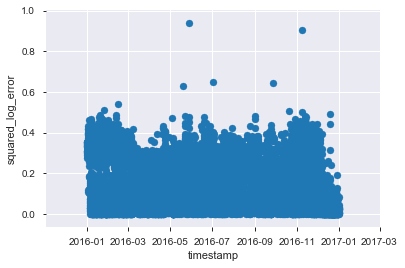

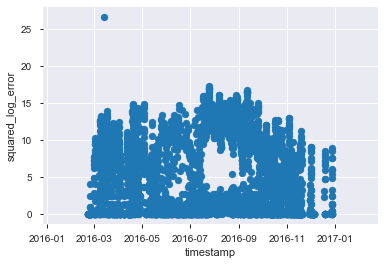

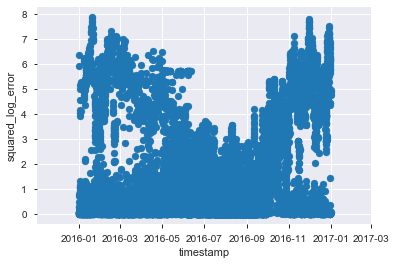

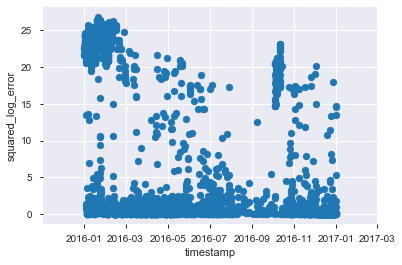

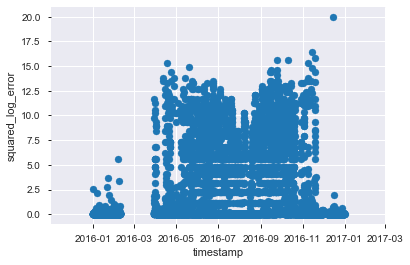

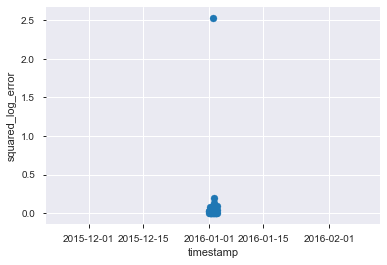

In [196]:
# plot the squared_log_error for a few dfs
plot_timeseries(elec_train_weekly_temp_preds, 'squared_log_error', 745)
plot_timeseries(chilledwater_train_weekly_temp_preds, 'squared_log_error', 745)
plot_timeseries(hotwater_train_weekly_temp_preds, 'squared_log_error', 106)
plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 745)

plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 1442)   
plot_timeseries(steam_train_weekly_temp_preds, 'squared_log_error', 1442,
                timestamp_start='2016-01-01 00:00:00',
                timestamp_end='2016-01-03 00:00:00') # not working nicely...


In [102]:
#suprisingly - elec data looks the best in many ways. How can this be when temp a poor correlator?
# perhaps just because some very odd/erroneous values in the other datasets? Need to understand this better

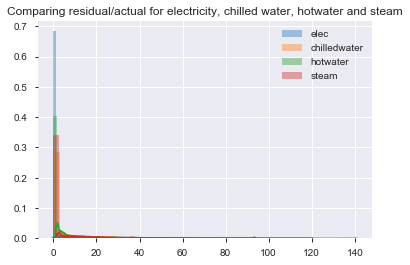

In [197]:
#plot the distribution of the log squared errors
def compare_distributions(df_dict, variable_name_dict, title):
    for df_name, df in df_dict.items():
        sns.distplot(list(df[variable_name_dict[df_name]].dropna()), label=df_name)
    plt.title(title)
    plt.legend()
    plt.show()
    
variable_name_dict = {'elec': 'squared_log_error',
                      'chilledwater':'squared_log_error',
                      'hotwater':'squared_log_error', 
                      'steam':'squared_log_error'}

df_dict_compare_errors = {'elec': elec_train_weekly_temp_preds,
                             'chilledwater': chilledwater_train_weekly_temp_preds,
                             'hotwater':hotwater_train_weekly_temp_preds,
                             'steam': steam_train_weekly_temp_preds}

compare_distributions(df_dict_compare_errors ,
                      variable_name_dict,
                     'Comparing residual/actual for electricity, chilled water, hotwater and steam')    

In [112]:
#some issues with huge erros in the steam and chilled water datasets - need to find them

In [198]:
steam_train_weekly_temp_preds

meter  meter_reading meter_type  site_id  \
building_id timestamp                                                       
745         2016-01-01 00:00:00      2         0.0000      steam        6   
            2016-01-01 01:00:00      2         0.0000      steam        6   
            2016-01-01 02:00:00      2         0.0000      steam        6   
            2016-01-01 03:00:00      2         0.0000      steam        6   
            2016-01-01 04:00:00      2         0.0000      steam        6   
...                                ...            ...        ...      ...   
1442        2016-12-31 19:00:00      2        63.4563      steam       15   
            2016-12-31 20:00:00      2        52.9570      steam       15   
            2016-12-31 21:00:00      2        70.2051      steam       15   
            2016-12-31 22:00:00      2        63.6180      steam       15   
            2016-12-31 23:00:00      2        55.6241      steam       15   

                                     primary_use  square_feet  year_built  \
building_id timestamp                                                       
745         2016-01-01 00:00:00        Education        13512         NaN   
            2016-01-01 01:00:00        Education        13512         NaN   
            2016-01-01 02:00:00        Education        13512         NaN   
            2016-01-01 03:00:00        Education        13512         NaN   
            2016-01-01 04:00:00        Education        13512         NaN   
...                                          ...          ...         ...   
1442        2016-12-31 19:00:00  Public services        99541      1993.0   
            2016-12-31 20:00:00  Public services        99541      1993.0   
            2016-12-31 21:00:00  Public services        99541      1993.0   
            2016-12-31 22:00:00  Public services        99541      1993.0   
            2016-12-31 23:00:00  Public services        99541      1993.0   

                                 floor_count  air_temperature  cloud_coverage  \
building_id timestamp                                                           
745         2016-01-01 00:00:00          NaN             10.0        0.000000   
            2016-01-01 01:00:00          NaN             10.0        0.000000   
            2016-01-01 02:00:00          NaN             10.0        0.666667   
            2016-01-01 03:00:00          NaN              9.4        1.333333   
            2016-01-01 04:00:00          NaN              7.8        2.000000   
...                                      ...              ...             ...   
1442        2016-12-31 19:00:00          NaN              3.0        1.500000   
            2016-12-31 20:00:00          NaN              2.8        2.000000   
            2016-12-31 21:00:00          NaN              2.8        2.000000   
            2016-12-31 22:00:00          NaN              2.2        2.000000   
            2016-12-31 23:00:00          NaN              1.7        2.000000   

                                 ...  is_weekend      r_sq  temp_coef  \
building_id timestamp            ...                                    
745         2016-01-01 00:00:00  ...           0  0.509890  -4.065321   
            2016-01-01 01:00:00  ...           0  0.509890  -4.065321   
            2016-01-01 02:00:00  ...           0  0.509890  -4.065321   
            2016-01-01 03:00:00  ...           0  0.509890  -4.065321   
            2016-01-01 04:00:00  ...           0  0.509890  -4.065321   
...                              ...         ...       ...        ...   
1442        2016-12-31 19:00:00  ...           0  0.956226  -2.761813   
            2016-12-31 20:00:00  ...           0  0.956226  -2.761813   
            2016-12-31 21:00:00  ...           0  0.956226  -2.761813   
            2016-12-31 22:00:00  ...           0  0.956226  -2.761813   
            2016-12-31 23:00:00  ...           0  0.956226  -2.761813   

                         

In [116]:
del df_dict_compare_residuals 

### 3.1.4 Evaluate performance of simple linear regression based on weekly averages

In [105]:
def extract_predictions(df, column_header):
    predictions = df[column_header].to_numpy()
    predictions[predictions < 0] = 0
    return predictions

In [166]:
#elec
elec_predictions = extract_predictions(elec_train_weekly_temp_preds,'temp_based_prediction')
elec_actuals = elec_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(elec_predictions, elec_actuals)

0.6863533241514536

In [167]:
#chilledwater
chilledwater_predictions = extract_predictions(chilledwater_train_weekly_temp_preds,'temp_based_prediction')
chilledwater_actuals = chilledwater_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(chilledwater_predictions, chilledwater_actuals)

1.9142380509528318

In [168]:
#hotwater
hotwater_predictions = extract_predictions(hotwater_train_weekly_temp_preds,'temp_based_prediction')
hotwater_actuals = hotwater_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(hotwater_predictions, hotwater_actuals)

1.9245298934259893

In [169]:
#steam
steam_predictions = extract_predictions(steam_train_weekly_temp_preds,'temp_based_prediction')
steam_actuals = steam_train_weekly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(steam_predictions, steam_actuals)

1.9207773626466587

In [176]:
# all together
predictions = np.concatenate([elec_predictions, chilledwater_predictions,hotwater_predictions, steam_predictions])
actuals = np.concatenate([elec_actuals, chilledwater_actuals,hotwater_actuals, steam_actuals])
calculate_RMSLE_score(predictions, actuals)

1.3370144760569052

### 3.1.5 Produce a set of predictions on the test set based on this weekly average temperature model

In [110]:
def add_weather_variables_to_test_df(test, building, weather, weather_variables):
    
    # add site id to test data
    building_site_id = building[['site_id','building_id']].set_index('building_id').to_dict()['site_id']
    test_with_site_id = test.copy()
    test_with_site_id['site_id'] = test_with_site_id['building_id'].map(building_site_id )
    
    # add required weather variables to test data
    required_weather = weather[['site_id', 'timestamp'] + weather_variables]
    all_df = test_with_site_id.merge(required_weather, on = ['site_id', 'timestamp'], how='left')
    
    #multi index on building id and timestamp to match previous format
    all_df = all_df.set_index(['building_id', 'timestamp']).sort_index()
    
    return all_df

In [118]:
test_with_air_temp = add_weather_variables_to_test_df(test, building, weather_test, ['air_temperature'])

In [119]:
# very slow
test_weekly_temp_preds = add_temp_based_predictions(test_with_air_temp, df_weekly_results)

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [121]:
test_with_air_temp

row_id  meter   meter_type  site_id  \
building_id timestamp                                                    
0           2017-01-01 00:00:00         0      0  electricity        0   
            2017-01-01 01:00:00       129      0  electricity        0   
            2017-01-01 02:00:00       258      0  electricity        0   
            2017-01-01 03:00:00       387      0  electricity        0   
            2017-01-01 04:00:00       516      0  electricity        0   
...                                   ...    ...          ...      ...   
1448        2018-12-31 19:00:00  41497570      0  electricity       15   
            2018-12-31 20:00:00  41497820      0  electricity       15   
            2018-12-31 21:00:00  41498070      0  electricity       15   
            2018-12-31 22:00:00  41498320      0  electricity       15   
            2018-12-31 23:00:00  41498570      0  electricity       15   

                                 air_temperature  
building_id timestamp                             
0           2017-01-01 00:00:00             17.8  
            2017-01-01 01:00:00             17.8  
            2017-01-01 02:00:00             16.1  
            2017-01-01 03:00:00             17.2  
            2017-01-01 04:00:00             16.7  
...                                          ...  
1448        2018-12-31 19:00:00              3.3  
            2018-12-31 20:00:00              2.8  
            2018-12-31 21:00:00              2.8  
            2018-12-31 22:00:00              2.8  
            2018-12-31 23:00:00              3.3  

[41697600 rows x 5 columns]

In [120]:
test_weekly_temp_preds

row_id  meter   meter_type  site_id  \
building_id timestamp                                                    
0           2017-01-01 00:00:00         0      0  electricity        0   
            2017-01-01 01:00:00       129      0  electricity        0   
            2017-01-01 02:00:00       258      0  electricity        0   
            2017-01-01 03:00:00       387      0  electricity        0   
            2017-01-01 04:00:00       516      0  electricity        0   
...                                   ...    ...          ...      ...   
1448        2018-12-31 19:00:00  41497570      0  electricity       15   
            2018-12-31 20:00:00  41497820      0  electricity       15   
            2018-12-31 21:00:00  41498070      0  electricity       15   
            2018-12-31 22:00:00  41498320      0  electricity       15   
            2018-12-31 23:00:00  41498570      0  electricity       15   

                                 air_temperature      r_sq  temp_coef  \
building_id timestamp                                                   
0           2017-01-01 00:00:00             17.8  0.615900   9.206641   
            2017-01-01 01:00:00             17.8  0.615900   9.206641   
            2017-01-01 02:00:00             16.1  0.615900   9.206641   
            2017-01-01 03:00:00             17.2  0.615900   9.206641   
            2017-01-01 04:00:00             16.7  0.615900   9.206641   
...                                          ...       ...        ...   
1448        2018-12-31 19:00:00              3.3  0.400999  -0.017766   
            2018-12-31 20:00:00              2.8  0.400999  -0.017766   
            2018-12-31 21:00:00              2.8  0.400999  -0.017766   
            2018-12-31 22:00:00              2.8  0.400999  -0.017766   
            2018-12-31 23:00:00              3.3  0.400999  -0.017766   

                                 intercept  set_point_temp  \
building_id timestamp                                        
0           2017-01-01 00:00:00   6.583601       -0.715093   
            2017-01-01 01:00:00   6.583601       -0.715093   
            2017-01-01 02:00:00   6.583601       -0.715093   
            2017-01-01 03:00:00   6.583601       -0.715093   
            2017-01-01 04:00:00   6.583601       -0.715093   
...                                    ...             ...   
1448        2018-12-31 19:00:00   3.530175      198.703946   
            2018-12-31 20:00:00   3.530175      198.703946   
            2018-12-31 21:00:00   3.530175      198.703946   
            2018-12-31 22:00:00   3.530175      198.703946   
            2018-12-31 23:00:00   3.530175      198.703946   

                                 temp_based_prediction  
building_id timestamp                                   
0           2017-01-01 00:00:00             170.461809  
            2017-01-01 01:00:00             170.461809  
            2017-01-01 02:00:00             154.810519  
            2017-01-01 03:00:00             164.937824  
            2017-01-01 04:00:00             160.334504  
...                                                ...  
1448        2018-12-31 19:00:00               3.471547  
            2018-12-31 20:00:00               3.480430  
            2018-12-31 21:00:00               3.480430  
            2018-12-31 22:00:00               3.480430  
            2018-12-31 23:00:00               3.471547  

[41697600 rows x 10 columns]

In [122]:
predictions = test_weekly_temp_preds[['row_id', 'temp_based_prediction']].copy()
predictions = predictions.reset_index()[['row_id', 'temp_based_prediction']]
predictions = predictions.set_index('row_id')
predictions = predictions.rename(columns = {'temp_based_prediction':'meter_reading'})
predictions = predictions.sort_index(0)

In [123]:
predictions

,meter_reading
row_id,
0,170.461809
1,82.442666
2,8.835770
3,315.626380
4,1377.208553
...,...
41697595,7.446401
41697596,4.739106
41697597,3.608644


In [126]:
predictions.to_csv('weekly_temp_means_submission.csv')

In [127]:
len(predictions)

41697600

### 3.1.6 Look at what correlates with the residuals

In [180]:
elec_residuals_corr = produce_correlation_df(elec_train_weekly_temp_preds, y_variable='residual')
hotwater_residuals_corr = produce_correlation_df(hotwater_train_weekly_temp_preds, y_variable='residual')
chilledwater_residuals_corr = produce_correlation_df(chilledwater_train_weekly_temp_preds, y_variable='residual')
steam_residuals_corr = produce_correlation_df(steam_train_weekly_temp_preds, y_variable='residual')

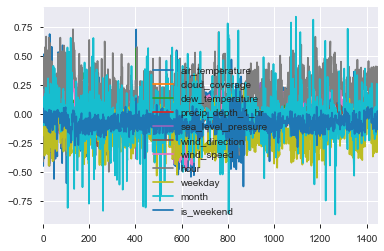

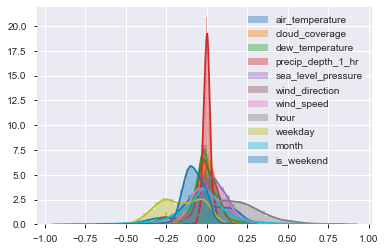

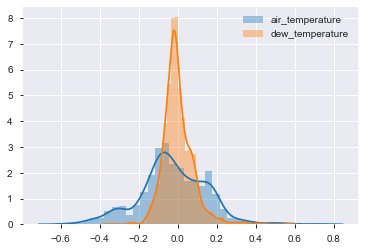

In [181]:
explore_correlations(elec_residuals_corr)

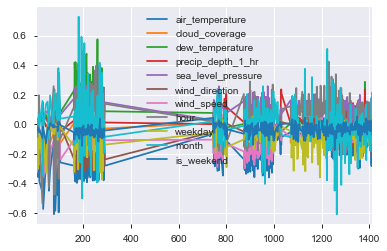

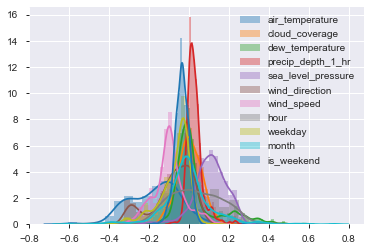

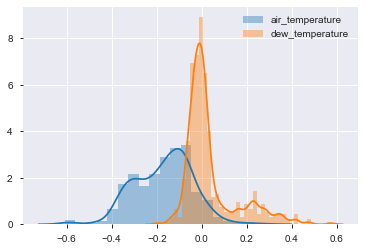

In [182]:
explore_correlations(chilledwater_residuals_corr)

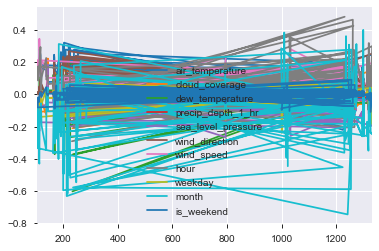

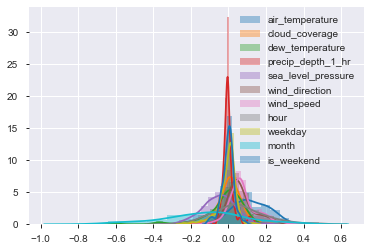

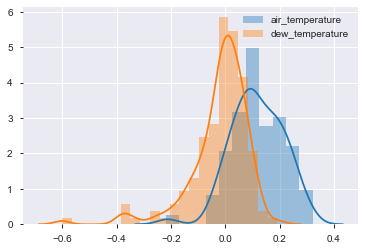

In [183]:
explore_correlations(hotwater_residuals_corr)

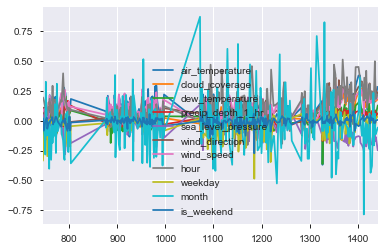

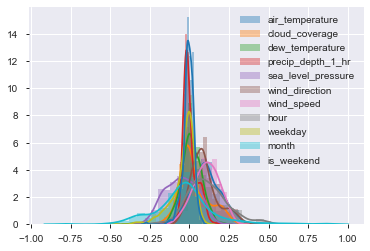

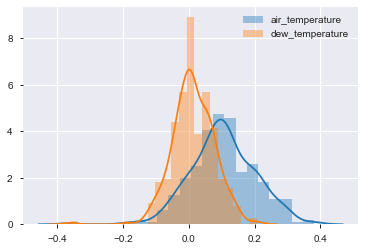

In [184]:
explore_correlations(steam_residuals_corr)

In [185]:
# Hmm - why is there any signal left in air temp? I suppose the temperature dependance is not independant of time.
# Perhaps because the set point temperature changes with time
# Time seems important. As a dump option, try and just add the whole residual back onto the test set?


### 3.1.7 Add residuals back in to temp based predictions 

This will obviously give perfect results here but worth a submission attempt in case it works well
Won't deal with the variation in set point temperature well but should do an ok job with the other time dependance

## 3.2 Air temperaure - hourly data

### 3.2.1 Fit to hourly data

In [136]:
df_steam_hourly_results = fit_linear_regression_to_air_temp_data(steam_train)
df_chilledwater_hourly_results = fit_linear_regression_to_air_temp_data(chilledwater_train)
df_hotwater_hourly_results = fit_linear_regression_to_air_temp_data(hotwater_train)
df_elec_hourly_results = fit_linear_regression_to_air_temp_data(elec_train) 

In [137]:
#add meter numbers (this is kinda silly - should just keep them in earlier)
df_elec_hourly_results['meter'] = 0
df_chilledwater_hourly_results['meter'] = 1
df_steam_hourly_results['meter'] = 2
df_hotwater_hourly_results['meter'] = 3

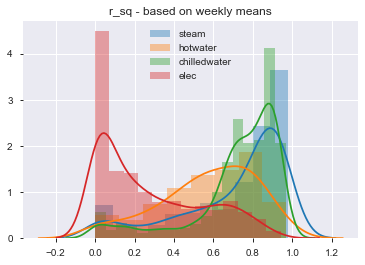

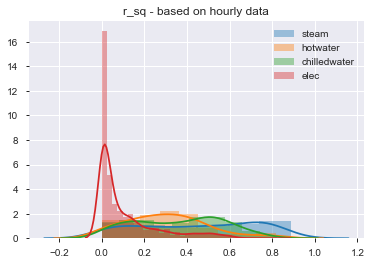

In [138]:
variable_name_dict = {'steam':'r_sq',
                      'hotwater':'r_sq',
                      'chilledwater':'r_sq',
                      'elec':'r_sq'}

compare_distributions({'steam':df_steam_weekly_results,
                      'hotwater': df_hotwater_weekly_results,
                      'chilledwater':df_chilledwater_weekly_results,
                      'elec': df_elec_weekly_results},
                      variable_name_dict,
                      'r_sq - based on weekly means')

compare_distributions({'steam':df_steam_hourly_results,
                      'hotwater': df_hotwater_hourly_results,
                      'chilledwater':df_chilledwater_hourly_results,
                      'elec': df_elec_hourly_results},
                      variable_name_dict,
                      'r_sq - based on hourly data')

### 3.2.3 Evaluate performance of simple linear regression based on hourly temp data

In [139]:
elec_train_hourly_temp_preds = add_temp_based_predictions(elec_train, df_elec_hourly_results)
chilledwater_train_hourly_temp_preds = add_temp_based_predictions(chilledwater_train,
                                                                  df_chilledwater_hourly_results)
hotwater_train_hourly_temp_preds = add_temp_based_predictions(hotwater_train, df_hotwater_hourly_results)
steam_train_hourly_temp_preds = add_temp_based_predictions(steam_train, df_steam_hourly_results)

/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/envs/ASHRAE/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [140]:
elec_predictions = extract_predictions(elec_train_hourly_temp_preds,'temp_based_prediction')
elec_actuals = elec_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(elec_predictions, elec_actuals)

0.6806904018219141

In [141]:
chilledwater_predictions = extract_predictions(chilledwater_train_hourly_temp_preds,'temp_based_prediction')
chilledwater_actuals = chilledwater_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(chilledwater_predictions, chilledwater_actuals)

1.8704513031264483

In [142]:
hotwater_predictions = extract_predictions(hotwater_train_hourly_temp_preds,'temp_based_prediction')
hotwater_actuals = hotwater_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(hotwater_predictions, hotwater_actuals)

1.9263692332853317

In [177]:
steam_predictions = extract_predictions(steam_train_hourly_temp_preds,'temp_based_prediction')
steam_actuals = steam_train_hourly_temp_preds['meter_reading'].to_numpy()
calculate_RMSLE_score(steam_predictions, steam_actuals)

1.8795374327090197

In [178]:
# all together
predictions = np.concatenate([elec_predictions, chilledwater_predictions,hotwater_predictions, steam_predictions])
actuals = np.concatenate([elec_actuals, chilledwater_actuals,hotwater_actuals, steam_actuals])
calculate_RMSLE_score(predictions, actuals)

1.3290006021174336

In [179]:
# so the hourly model actually does better. Perhaps because it intrinsically deals with some time dependance?

# Learnings

- Weather data is for 1 year - 2016
- Their are 16 sites we have weather data for
- Temperature data is good - no missing values. Other weather data less so. 
- Weather data and meter data is missing some hours of the year. Meter data has all hours that weather data has
- No clear pattern to where data is missing
<br/>

- There can be multiple meters per building
- We need to learn seperate models for each meter. It may be hard to generalise learnings for the same building. 
- We need to predict meter readings hourly
<br/>

- Weekly mean air temperature strongly and consistently correlates with mean meter reading for all meaters apart from electricity 
- Weekly degree hours also strongly correlation with total weekly consumption - but relationship is slightly less good than for averages. Could be because of the changing balance point
- Other weather data not particularly important - so start with temperature
- Time dependance not really explored yet - instead learning attibutes about temperature dependance based on weekly data and then using those for hourly data
- The strength of temperature as a predictor varies between building types - It is strongest for office buildings and lodging/residential. Education buildings have much bigger drop offs in the summer than you would expect based on temperature alone - presumeably because they are not used

# To Explore

- make a meter object...?
- some part of meter reading should correlate with temperature - what about summing all of the meter readings together and seeing then seperating out use? Issue is that we don't know if they are in the same unit
- change timestamp data to local time
- Add residuals back in just based on building, meter and timestamp

